<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-общей-информации-о-данных" data-toc-modified-id="Изучение-общей-информации-о-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение общей информации о данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Логистическая-регрессия-с-BERT" data-toc-modified-id="Логистическая-регрессия-с-BERT-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Логистическая регрессия с BERT</a></span></li><li><span><a href="#Оптимизация-гиперпараметров-LightGBM" data-toc-modified-id="Оптимизация-гиперпараметров-LightGBM-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Оптимизация гиперпараметров LightGBM</a></span></li><li><span><a href="#Дообучение-и-проверка-на-тестовой-выборке" data-toc-modified-id="Дообучение-и-проверка-на-тестовой-выборке-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Дообучение и проверка на тестовой выборке</a></span></li><li><span><a href="#Сравнение-с-DummyClassifier" data-toc-modified-id="Сравнение-с-DummyClassifier-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Сравнение с DummyClassifier</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Модель классификации токсичных комментариев для интернет-магазина

Перед нами набор данных с разметкой о токсичности правок.

Наша задача - построить модель, способную распознавать токсичность в правках и комментариях для последующей отправки таких сообщений на рассмотрение модераторам. Модель, способная классифицировать комментарии на позитивные и негативные, поможет сократить объемы работы модераторов и защитить аудиторию от нежелательного контента.

Требование к модели - значение метрики качества `F1` не меньше 0.75. 

Исследование поделено на три основные части:

- 1) Изучение общей информации о данных
- 2) Предобработка данных
- 2) Обучение модели:
        - Выбор подходящих моделей
        - Разделение данных на выборки
        - Обучение и выбор лучшей модели
        - Дообучение и тестирование
        - Сравнение с DummyClassifier
    
- 3) Общий вывод по проделанной работе

**Описание данных:**

- `toxic` — целевой признак.
- `text` - текст комментария

## Изучение общей информации о данных

Импортируем модули.

In [1]:
import warnings
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import torch
import transformers

from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier

# скрыть предупреждения
warnings.simplefilter('ignore')
# загрузка языкового пакета для spacy
!spacy download en
spacy.load('en_core_web_sm')
# RandomState
state = np.random.RandomState(12345)

                                              0.0/12.8 MB ? eta -:--:--
                                              0.1/12.8 MB 1.7 MB/s eta 0:00:08
                                              0.2/12.8 MB 3.0 MB/s eta 0:00:05
     -                                        0.6/12.8 MB 4.3 MB/s eta 0:00:03
     --                                       0.9/12.8 MB 5.0 MB/s eta 0:00:03
     ---                                      1.2/12.8 MB 5.4 MB/s eta 0:00:03
     ----                                     1.5/12.8 MB 5.6 MB/s eta 0:00:03
     -----                                    1.8/12.8 MB 5.9 MB/s eta 0:00:02
     ------                                   2.2/12.8 MB 6.0 MB/s eta 0:00:02
     -------                                  2.4/12.8 MB 5.9 MB/s eta 0:00:02
     -------                                  2.5/12.8 MB 5.5 MB/s eta 0:00:02
     --------                                 2.7/12.8 MB 5.1 MB/s eta 0:00:02
     ----------                               3.3/12.8 MB 5

Импортируем данные.

In [2]:
data = pd.read_csv('datasets/toxic_comments.csv')

Выведем первые 5 строк датафрейма и основную информацию о нём.

In [3]:
data.head(5)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Данные загружены корректно, первичный осмотр проведен.</font>

<Axes: >

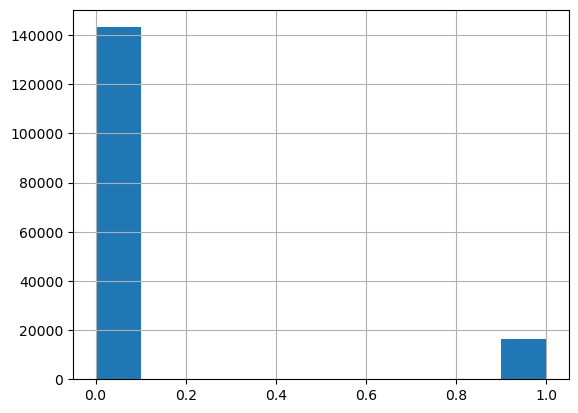

In [5]:
data['toxic'].hist()

**Вывод:** Целостность данных сохранена, наблюдается явный дисбаланс классов целевого признака в пользу позитивных комментариев.

## Предобработка данных

Удалим из данных пустой столбец `Unnamed: 0`

In [6]:
data = data.drop('Unnamed: 0', axis=1)

Подготовим текст для обучения логистической регрессии: очистим текст от символов и лемматизируем слова - этот шаг поможет сократить количество уникальных слов и, как следствие, улучшит качество предсказаний.

In [7]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\'\ ]', ' ', text)
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.split()
    text = " ".join(text)
    doc = nlp(text)
    text = " ".join([token.lemma_ for token in doc])
    return text

tqdm.pandas()
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data['text'] = data['text'].progress_apply(clean_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [8]:
data.head()

,text,toxic
0,Explanation why the edit make under my usernam...,0
1,Daww he match this background colour I m seemi...,0
2,hey man I m really not try to edit war its jus...,0
3,More I can not make any real suggestion on imp...,0
4,you sir be my hero any chance you remember wha...,0


Вывод: Данные очищены от лишних символов и лемматизированы.

## Обучение модели

Перед нами стоит задача классифицкации. Для сравнения были выбраны LogisticRegression, LightGBM и нейронная модель BERT. Модели требуют дополнительной подготовки данных. Выделим из данных предиктор и целевой признак.


In [9]:
features = data['text']
y = data['toxic']

Так как тестовой выборки не предусмотрено, разделим имеющиеся данные на 3 части: Тренировочную (60% данных), валидационную (20%) и тестовую (20%). Параметр stratify позволит нам добиться равного распледеления целевого признака по всем выборкам.

In [10]:
def split_data(X_set, y_set, t_size=0.6, test=True):
    
    X_tr, X_temp, y_tr, y_temp = \
    train_test_split(X_set, y_set,
                     train_size=t_size, 
                     stratify=y_set,
                     random_state=state)
    
    if test:
        X_val, X_t, y_val, y_t = \
        train_test_split(X_temp, y_temp,
                         test_size=0.5,
                         stratify=y_temp,
                         random_state=state)
        return X_tr, X_val, X_t, y_tr, y_val, y_t
    else:
        return X_tr, X_temp, y_tr, y_temp

X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(features, y)

Переведём предиктор в векторы (их будем использовать как предиктор для регрессии, леса и градиентного бустинга)

In [11]:
cv = CountVectorizer(dtype=np.float32).fit(X_train)

X_train_cv = cv.transform(X_train)
X_valid_cv = cv.transform(X_valid)
X_test_cv = cv.transform(X_test)

### LogisticRegression

Обучим логистическую регрессию (гиперпараметр `class_weight='balanced'` поможет сгладить неравенство целевого признака).

In [12]:
def f1_pred(X, y):
    y_pred = model.predict(X)
    print(f'Метрика F1 =', f1_score(y_pred, y))

model = LogisticRegression(random_state=state, class_weight='balanced').fit(X_train_cv, y_train)
f1_pred(X_valid_cv, y_valid)

Метрика F1 = 0.7520178124130252


Модель LogisticRegression едва удовлетворяет условию задачи.

### RandomForestClassifier

Обучим базовый случайный лес.

In [13]:
model = RandomForestClassifier(random_state=state).fit(X_train_cv, y_train)
f1_pred(X_valid_cv, y_valid)

Метрика F1 = 0.567437800087298


Случайный лес не удовлетворяет условию задачи.

### LightGBM

Обучим базовый LGBMClassifier.

In [14]:
model = LGBMClassifier(random_state=state).fit(X_train_cv, y_train)
f1_pred(X_valid_cv, y_valid)

Метрика F1 = 0.7552346570397113


LightGBM удовлетворяет условию поставленной задачи.

### Логистическая регрессия с BERT

Загрузим модель и конфигурацию.

In [15]:
configuration = transformers.BertConfig.from_pretrained(
    'unitary/toxic-bert')

model = transformers.BertModel.from_pretrained(
    'unitary/toxic-bert', configuration)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Так как работа с BERT очень времязатратна, возьмём из данных только 5000 строк и токенизируем их.

In [17]:
sample_n = 5000

temp = data.sample(sample_n, random_state=state)
features_bert = temp['text']
target_bert = temp['toxic']

tokenizer = transformers.BertTokenizer.from_pretrained('unitary/toxic-bert')

tokenized = features_bert.progress_apply(
    lambda x: tokenizer.encode(
        x,
        add_special_tokens=True,
        truncation=True,
        max_length=512
    )
)

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [18]:
batch_size = 10
embeddings = []

for i in tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())
features_bert = np.concatenate(embeddings)

  0%|          | 0/500 [00:00<?, ?it/s]

Разделим данные на выборки.

In [19]:
X_train_bert, X_valid_bert, X_test_bert, y_train_bert, y_valid_bert, y_test_bert =\
split_data(features_bert, target_bert, t_size=0.6)

Обучим модель и выведем значение F1.

In [20]:
model = LogisticRegression(random_state=state, class_weight='balanced').fit(X_train_bert, y_train_bert)
f1_pred(X_valid_bert, y_valid_bert)

Метрика F1 = 0.8755760368663594


Даже с небольшим объемом обработанных данных модель BERT показывает очень хороший результат, но процесс подготовки и обработки данных крайне продолжительный и ресурсозатратный.

### Оптимизация гиперпараметров LightGBM

 Подберём оптимальные гиперпараметры.

In [21]:
param_grid = {
    'boosting_type': ['gbdt', 'goss'],
    'n_estimators': [100, 150, 200],
    'max_depth': [80, 90, 100],
    'num_leaves': [32, 64, 128]
}

model = LGBMClassifier(random_state=state)

gs = GridSearchCV(estimator=model,
                  param_grid=param_grid,
                  cv=3,
                  n_jobs=-1,
                  scoring='f1')
gs.fit(X_train_cv, y_train)

best_params = gs.best_estimator_
print(best_params)
print(f'Метрика F1 =', gs.best_score_)

LGBMClassifier(max_depth=90, n_estimators=200, num_leaves=128,
               random_state=RandomState(MT19937) at 0x2C00053DA40)
Метрика F1 = 0.7830131415838885


### Дообучение и проверка на тестовой выборке

Проверим метрику F1 на тестовых данных.

In [22]:
params = {
    'boosting_type':'goss',
    'max_depth':90, 
    'n_estimators':200, 
    'n_jobs':-1, 
    'num_leaves':128
}

model = LGBMClassifier(random_state=state, **params).fit(X_train_cv, y_train)
f1_pred(X_test_cv, y_test)

Метрика F1 = 0.7797364367619374


### Сравнение с DummyClassifier

Сравним полученную метрику F1 с метрикой DummyClassifier.

In [23]:
model = DummyClassifier(strategy='constant', constant=1, random_state=state).fit(X_train_cv, y_train)
f1_pred(X_test_cv, y_test)

Метрика F1 = 0.18446546614998857


Модель справляется с задачей, её значение F1 значительно превосходит значение метрики для модели, предсказывающей случайно.

## Общий вывод

Применение машинного обучения для обработки текстовых данных имеет ряд преимуществ:

1) Эффективность: автоматизированная система, способна обрабатывать огромные объемы контента в режиме реального времени. Алгоритмы машинного обучения могут быстро анализировать текст, чтобы определить наличие нежелательного контента, такого как спам, оскорбления, насилие или незаконные материалы.

2) Снижение нагрузки на модераторов: автоматическая фильтрация нежелательного контента помогает снизить нагрузку на модераторов, которые ранее были ответственны за ручную проверку и удаление такого контента. Автоматизированная система может предварительно отсеять большую часть нежелательного контента, оставляя модераторам более легкую задачу в ручном режиме проверить и удалить оставшиеся нарушения.

3) Сокращение времени реакции: благодаря скорости и эффективности алгоритмов машинного обучения, системы модерации могут обнаруживать и удалить нежелательный контент практически мгновенно. Это помогает предотвратить распространение нежелательных материалов и уменьшить вред, который они могут нанести пользователям и сообществам.

После предобработки полученных данных было рассмотрено применение для поставленной задачи таких моделей машинного обучения, как логистическая регрессия, случайный лес, классификатор на `LightGBM` и логистическая регрессия с применением предобученной модели BERT. Лучшие результаты (`F1_score = 0.78`) показала модель `LGBMClassifier` с подобранными гиперпараметрами 
- boosting_type='goss', 
- n_estimators=200, 
- max_depth=90,
- num_leaves=128`. 

При наличии свободных вычислительных мощностей целесообразно применение логистической регрессии на BERT, модель показала достаточно высокие значения метрики качества, не смотря на небольшой объем обучающих данных.